### Here we will follow three steps:
* Data Loading
* Model Builing
* Training and model training tracking
* Evaluation

In [2]:
import torch

#### Data Loading

In [3]:
# load the pickle files to obtain the data
import pickle
import numpy as np
from typing import Tuple

# load the data
def unpickle(file:str) -> dict:
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
 
def load_data_from_pickle(file:str) -> Tuple[np.ndarray,np.ndarray]:
    data_dict=unpickle(file)
    print(data_dict.keys())
    data=data_dict[b'data']
    labels=data_dict[b'labels']
    return data,labels

def load_cifar_data(download_dir_path:str) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray,dict]:
    train_data,train_labels=load_data_from_pickle(download_dir_path+"/data_batch_1")
    for i in range(2,6):
        data,labels=load_data_from_pickle(download_dir_path+"/data_batch_"+str(i))
        train_data=np.concatenate((train_data,data),axis=0)
        train_labels=np.concatenate((train_labels,labels),axis=0)
    test_data,test_labels=load_data_from_pickle(download_dir_path+"/test_batch")
    meta_data=unpickle(download_dir_path+"/batches.meta")
    return train_data,train_labels,test_data,test_labels,meta_data

train_data,train_labels,test_data,test_labels,meta_data=load_cifar_data("datasets/cifar-10/cifar-10-batches-py")

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [4]:
# to split train and test data
from sklearn.model_selection import train_test_split

# Assuming train_data and train_labels are your dataset and labels
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels
) #using stratify to ensure equal distribution of classes

# NOTE: Stratify ensures that the distribution of classes in the train and test datasets are similar(it will be same as the original dataset)
print("train_data.shape",train_data.shape)
print("val_data.shape",val_data.shape)

train_data.shape (40000, 3072)
val_data.shape (10000, 3072)


In [5]:
from torch.utils.data import Dataset,DataLoader

class CIFAR10Dataset(Dataset):
    def __init__(self,data:np.ndarray,labels:np.ndarray,transform=None):
        self.data=data
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        if self.transform:
            return self.transform(self.data[idx]),self.labels[idx]
        return self.data[idx],self.labels[idx]

In [6]:
import torchvision.transforms as T

# introduce some transforms to the data
import numpy as np
class one_d_to_three_d():
    def __call__(self,img:np.ndarray):
        r,g,b=np.split(img,3)
        converted_img=np.ones((32,32,3))
        converted_img[:,:,0]=r.reshape(32,32)
        converted_img[:,:,1]=g.reshape(32,32)
        converted_img[:,:,2]=b.reshape(32,32)
        return converted_img.astype("uint8")
    
transforms=T.Compose([one_d_to_three_d(),T.ToTensor()])

In [7]:


# create dataset
train_dataset=CIFAR10Dataset(train_data,train_labels,transform=transforms)
val_dataset=CIFAR10Dataset(val_data,val_labels,transform=transforms)

label_map={ind:name for ind,name in enumerate(meta_data[b'label_names'])}


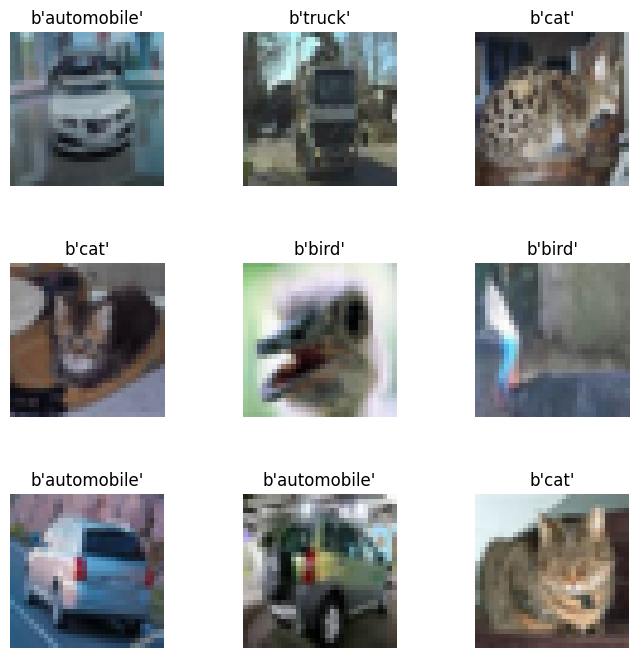

In [8]:
# let look at a single batch of data and preview the images
import matplotlib.pyplot as plt

train_data_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_data_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

images,labels=next(iter(train_data_loader))

fig=plt.figure(figsize=(8,8))
col,rows=3,3

for i in range(1, col * rows + 1):
    img = images[i - 1]
    label_name = label_map[labels[i - 1].item()]
    fig.add_subplot(rows, col, i)
    plt.title(label_name)
    plt.axis("off")
    img=(np.moveaxis(img.numpy(),0,-1)*255).astype("uint8") #convert C,H,W to H,W,C
    plt.imshow(img)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Add this line to adjust the spacing between subplots

plt.show()

#### Model Creation
We will create a VGGmini model.The architecture is as follows:
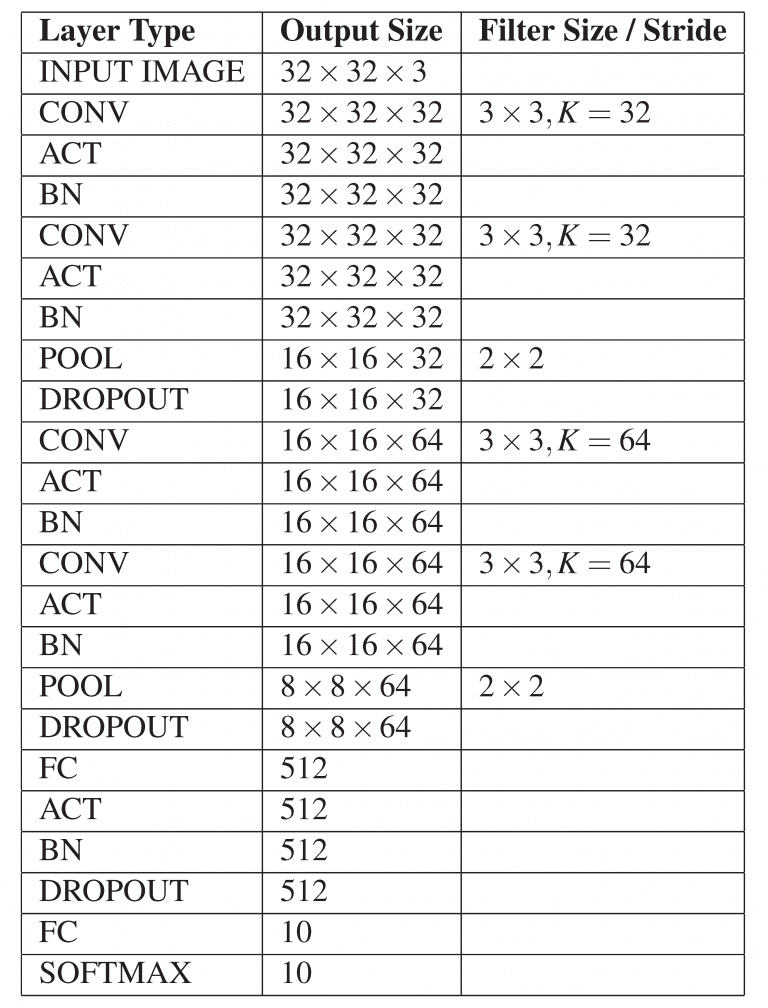


###### Let's study about some important layers present in this architecture:

1. Convolution Layer:
Convoliution layer perform discrete convolution operation between the input image and kernel.The kernel is slided all over the image and output at slide is basically the summation of all the value after multiplying the corresponding value of kernel to the corresponding value of image.In CNN we use multiple filters,each filter consist of number of kernels.The total number of kernels is same as the number of channels in input image.So for a particular filter,the total number of parameters is:
      
      * filter_dimension^2*(number of channels in input image)+1 (for bias)
    
The output dimension convolutional layer can be found using following formula:

$$
H_{out} = \left\lfloor \frac{H_{in} - K + 2 \cdot P}{S} \right\rfloor + 1
$$

$$
W_{out} = \left\lfloor \frac{W_{in} - K + 2 \cdot P}{S} \right\rfloor + 1
$$

Here K is the dimension of filter,P is the padding,and S is the stride

2. **Batch Normalization**

This operation applies normalization to hidden value(value before applying activation function) of each neuron over a mini batch.The output dimension is same as the input dimension.This layer increases the number of parameters by number of neurons in the present in the input layer.Please note that increase is not 2x as introducing the batch normalization reduces the effect of bias.

The mathematics is as follows:
Normalization:

For a given mini-batch of data, batch normalization normalizes the activations (outputs) of a layer. Suppose you have a mini-batch of \( m \) examples, each with \( d \) features. Let \( X \) be the input to the layer with shape \( (m, d) \).

The batch normalization process involves the following steps:

**Compute the Mean and Variance:**

For each feature \( j \) (where \( j \) ranges from 1 to \( d \)), compute the mean \( \mu_j \) and variance \( \sigma_j^2 \) over the mini-batch:

$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} X_{i,j}
$$

$$
\sigma_j^2 = \frac{1}{m} \sum_{i=1}^{m} (X_{i,j} - \mu_j)^2
$$

**Normalize the Activations:**

Normalize each feature \( j \) of the data:

$$
\hat{X}_{i,j} = \frac{X_{i,j} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}
$$

Here, \( \epsilon \) is a small constant added for numerical stability to avoid division by zero.

**Scale and Shift:**

After normalization, scale and shift the normalized activations using learnable parameters \( \gamma_j \) (scale) and \( \beta_j \) (shift):

$$
Y_{i,j} = \gamma_j \hat{X}_{i,j} + \beta_j
$$

Here, \( Y \) is the output of the batch normalization layer.

**Example:**

Let's walk through an example with a small mini-batch.

Assume we have a mini-batch with 2 examples and 3 features:

$$
X = \begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{bmatrix}
$$

**Compute Mean and Variance:**

Feature 1:

Mean: 
$$
\mu_1 = \frac{1 + 4}{2} = 2.5
$$

Variance: 
$$
\sigma_1^2 = \frac{(1 - 2.5)^2 + (4 - 2.5)^2}{2} = 2.25
$$

Feature 2:

Mean: 
$$
\mu_2 = \frac{2 + 5}{2} = 3.5
$$

Variance: 
$$
\sigma_2^2 = \frac{(2 - 3.5)^2 + (5 - 3.5)^2}{2} = 2.25
$$

Feature 3:

Mean: 
$$
\mu_3 = \frac{3 + 6}{2} = 4.5
$$

Variance: 
$$
\sigma_3^2 = \frac{(3 - 4.5)^2 + (6 - 4.5)^2}{2} = 2.25
$$

**Normalize the Activations:**

Feature 1:

$$
\hat{X}_{1,1} = \frac{1 - 2.5}{\sqrt{2.25 + \epsilon}} = -1
$$

$$
\hat{X}_{2,1} = \frac{4 - 2.5}{\sqrt{2.25 + \epsilon}} = 1
$$

Feature 2:

$$
\hat{X}_{1,2} = \frac{2 - 3.5}{\sqrt{2.25 + \epsilon}} = -1
$$

$$
\hat{X}_{2,2} = \frac{5 - 3.5}{\sqrt{2.25 + \epsilon}} = 1
$$

Feature 3:

$$
\hat{X}_{1,3} = \frac{3 - 4.5}{\sqrt{2.25 + \epsilon}} = -1
$$

$$
\hat{X}_{2,3} = \frac{6 - 4.5}{\sqrt{2.25 + \epsilon}} = 1
$$

**Scale and Shift:**

Suppose we set \( \gamma = 1 \) and \( \beta = 0 \) (i.e., no scaling or shifting):

$$
Y_{i,j} = \gamma \hat{X}_{i,j} + \beta = \hat{X}_{i,j}
$$

3. **Dropout**

Dropout is a regularization technique used in training artificial neural networks (ANNs) to prevent overfitting. During training, dropout randomly "drops out" or sets the output of certain neurons to zero. This forces the network to learn more robust features, as it cannot rely on any specific neurons.

Example: Suppose a neural network has a hidden layer with 10 neurons. If a dropout rate of 0.3 is applied, during each forward pass, approximately 3 out of the 10 neurons will be randomly dropped (set to zero).
Dropout in Mini-Batch Training
In mini-batch stochastic gradient descent (SGD), the network processes a batch of training examples together:

Forward Pass: Dropout is applied independently to each example in the mini-batch, meaning different neurons may be dropped for different examples.

Loss Calculation: The loss is computed for each example, and these losses are aggregated (typically summed or averaged) to produce a single loss value for the mini-batch.

Backward Pass: Gradients are computed based on the cumulative loss for the mini-batch. The same dropout masks used during the forward pass are applied in the backward pass.

Parameter Update: Gradient descent is applied only once per mini-batch based on the cumulative gradients from all examples in the batch.

This means that while gradients are computed for each example individually (considering their respective dropout masks), the actual update to the model's parameters occurs only once per mini-batch.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)) 
        self.batch_norm1=nn.BatchNorm2d(num_features=32)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)) 
        self.batch_norm2=nn.BatchNorm2d(num_features=32)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)) 
        self.batch_norm3=nn.BatchNorm2d(num_features=64)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3)) 
        self.batch_norm4=nn.BatchNorm2d(num_features=64)
        self.fc1=nn.Linear(in_features=5*5*64,out_features=512) #original w,h was 32,32 but after applying two max pools of size 2,2 and four conv operations of kernel size 3,3 with padding and stride as 0 it becomes 5,5
        self.batch_norm5=nn.BatchNorm1d(num_features=512)
        self.fc2=nn.Linear(in_features=512,out_features=10)

    def forward(self,x):
        #first block
        x=self.conv1(x)
        x=F.relu(x)
        x=self.batch_norm1(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.batch_norm2(x)
        x=F.max_pool2d(input=x,kernel_size=(2,2))
        x=F.dropout2d(x,p=0.5)

        #second block
        x=self.conv3(x)
        x=F.relu(x)
        x=self.batch_norm3(x)
        x=self.conv4(x)
        x=F.relu(x)
        x=self.batch_norm4(x)
        x=F.max_pool2d(input=x,kernel_size=(2,2))
        x=F.dropout2d(x,p=0.5)

        # fully connected network
        x=x.view(x.size(0),-1) #flattenning of tensor with batch size as x.size(0)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.batch_norm5(x)
        x=F.dropout1d(x,p=0.7)
        x=self.fc2(x)
        out=F.softmax(x)
        return out
    
# let print summary of model
model=CIFAR10Model()
from torchsummary import summary

summary(model=model,input_size=(3,32,32),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 30, 30]             896
       BatchNorm2d-2            [1, 32, 30, 30]              64
            Conv2d-3            [1, 32, 28, 28]           9,248
       BatchNorm2d-4            [1, 32, 28, 28]              64
            Conv2d-5            [1, 64, 12, 12]          18,496
       BatchNorm2d-6            [1, 64, 12, 12]             128
            Conv2d-7            [1, 64, 10, 10]          36,928
       BatchNorm2d-8            [1, 64, 10, 10]             128
            Linear-9                   [1, 512]         819,712
      BatchNorm1d-10                   [1, 512]           1,024
           Linear-11                    [1, 10]           5,130
Total params: 891,818
Trainable params: 891,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

/var/folders/jd/1xrx8xvj4013glk3d1lqbq5r0000gn/T/ipykernel_24908/3078517451.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=F.softmax(x)


In [10]:
# define basic configurations
epochs=100
learning_rate=0.001
batch_size=128
val_epochs=5 # after how many epochs to validate the model
project_name="cifar-10-project"
exp_name="exp1"
total_classes=10


In [13]:
from torch.utils.tensorboard import SummaryWriter
import torchvision 
from torch import Tensor,nn
from typing import Dict,List,Any
from tqdm.notebook import tqdm

def setup_exp_dir(project_name:str,exp_name:str)->str:
    import os
    os.makedirs(project_name,exist_ok=True)
    os.makedirs(project_name+"/"+exp_name,exist_ok=True)
    return project_name+"/"+exp_name

def save_some_train_sample_images(train_images,writer:SummaryWriter,step:int=0):
    tag="Train Image"
    img_grid=torchvision.utils.make_grid(tensor=train_images)
    writer.add_image(tag,img_grid,step)

def get_(gt_labels:Tensor,predicted_labels:Tensor) ->float:
    total=gt_labels.size(0)
    correct=(predicted_labels==gt_labels).sum().item()
    return correct/total

def gt_classwise_accuracy(gt_labels: torch.Tensor, predicted_labels: torch.Tensor) -> List[float]:
    # Get the unique classes in the ground truth labels
    classes = torch.unique(gt_labels)
    
    # Initialize a list to store accuracy for each class
    classwise_accuracy = []
    
    # Calculate accuracy for each class
    for cls in classes:
        # Get indices where the ground truth labels are equal to the current class
        class_indices = (gt_labels == cls)
        
        # Calculate the number of correct predictions for the current class
        correct_predictions = (predicted_labels[class_indices] == cls).sum().item()
        
        # Calculate the total number of samples for the current class
        total_samples = class_indices.sum().item()
        
        # Calculate the accuracy for the current class and append to the list
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
        classwise_accuracy.append(accuracy)
    
    return classwise_accuracy

def get_classwise_accuracy_data(gt_labels:Tensor,pred_labels:Tensor,total_class:int) -> np.ndarray:
    classes = torch.unique(gt_labels)

    acc_data=np.zeros((total_class,2))
    for cls in classes:
        # Get indices where the ground truth labels are equal to the current class
        class_indices = (gt_labels == cls)
        total_class_labels=class_indices.sum().item()
        total_correct_predictions=(pred_labels[class_indices] == cls).sum().item()
        acc_data[cls]=[total_correct_predictions,total_class_labels]
    return acc_data
        
def get_validation_metrics(model:nn.Module,val_images:Tensor,val_labels:Tensor,loss_calc:nn.CrossEntropyLoss,total_class:int) -> Tuple[float,np.ndarray]:
    predicts=model(val_images)
    loss=loss_calc(predicts,val_labels) #gives average loss
    _,predicted_labels=torch.max(predicts,dim=1) #give indices of max logit of each image is the batch aka final predicted label id for each image size is (N,)
    acc_data=get_classwise_accuracy_data(gt_labels=val_labels,pred_labels=predicted_labels,total_class=total_class)
    return loss.item(),acc_data

def save_model(exp_dir: str, model: nn.Module) -> None:
    """
    Saves the given PyTorch model to the specified directory.

    Parameters:
    exp_dir (str): The directory where the model should be saved.
    model (nn.Module): The PyTorch model to be saved.

    Returns:
    None
    """
    import os
    
    # Define the model save path
    model_save_path = os.path.join(exp_dir, f'best_model.pth')
    
    # Save the model state dictionary
    torch.save(model.state_dict(), model_save_path)
    
    print(f'Model saved to {model_save_path}')


def run_validation(model:nn.Module,val_data_loader:DataLoader,epoch:int,summary_writer:SummaryWriter,exp_dir:str,loss_calc:nn.CrossEntropyLoss,total_class:int,best_accuracy:float=None) -> None:
    total_loss=0
    total_class_wise_acc_data=np.zeros((total_class,2))
    total_steps=len(val_data_loader)
    step=0
    for images,labels in tqdm(val_data_loader):
        step+=1
        loss,acc_data=get_validation_metrics(model=model,val_images=images,val_labels=labels,loss_calc=loss_calc,total_class=total_class)
        total_loss+=loss
        total_class_wise_acc_data+=acc_data

    average_loss=total_loss/total_steps
    class_wise_accuracy={str(label_map[i]):val for i,val in enumerate(total_class_wise_acc_data[:,0]/total_class_wise_acc_data[:,1])}
    total_accuracy=total_class_wise_acc_data[:,0].sum()/total_class_wise_acc_data[:,1].sum()

    print(f"[INFO]Average Validation Loss at the end of {epoch}: {average_loss}")
    print(f"[INFO]Average Total Accuracy at the end of {epoch}: {total_accuracy}")
    print(f"[INFO]Class Wise Accuracy {epoch}: {class_wise_accuracy}")

    summary_writer.add_scalars("Class Wise Accuracy",class_wise_accuracy,epoch)
    summary_writer.add_scalar("Validation Loss",average_loss,epoch)
    summary_writer.add_scalar("Total Accuracy",total_accuracy,epoch)

    if best_accuracy is None or total_accuracy>best_accuracy:
        print("Updating the Best Model")
        save_model(exp_dir=exp_dir,model=model)

    return average_loss,class_wise_accuracy,total_accuracy
# get dataset loader
train_data_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_data_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)


In [14]:
#set up directors
exp_log_dir=setup_exp_dir(project_name=project_name,exp_name=exp_name)

summary_writer=SummaryWriter(exp_log_dir)
model=CIFAR10Model()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_func=nn.CrossEntropyLoss()
total_steps=len(train_data_loader) # total steps performed in one epoch
best_accuracy=None

for epoch in range(epochs):
    total_loss=0 #cumulative loss of epoch
    step=0
    print(f"Epoch: {epoch}")
    for images,labels in tqdm(train_data_loader):
        if epoch==0 and step==0:
            save_some_train_sample_images(train_images=images,writer=summary_writer)
        step+=1
        preds=model(images)
        loss=loss_func(preds,labels)
        total_loss+=loss.item()
        # print(f"[INFO]Training Loss at epoch {epoch}: {loss.item()} [{step}/{total_steps}]")
        loss.backward() #backward propagation to calc gradient
        optimizer.step() #updating the weigths
        optimizer.zero_grad() #making gradient zero so that it does add with next batch gradient
    
    average_loss=total_loss/total_steps
    print(f"[INFO]Average Training Loss at the end of {epoch}: {average_loss}")
    summary_writer.add_scalar(tag="Training Loss",scalar_value=average_loss,global_step=epoch)
    _,_,val_accuracy=run_validation(model=model,val_data_loader=val_data_loader,summary_writer=summary_writer,best_accuracy=best_accuracy,epoch=epoch,exp_dir=exp_log_dir,loss_calc=loss_func,total_class=total_classes)

    if best_accuracy is None or val_accuracy > best_accuracy:
        best_accuracy=val_accuracy


Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

/var/folders/jd/1xrx8xvj4013glk3d1lqbq5r0000gn/T/ipykernel_24908/3078517451.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=F.softmax(x)


[INFO]Average Training Loss at the end of 0: 2.306684417084764


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 0: 2.3046789561645893
[INFO]Average Total Accuracy at the end of 0: 0.1028
[INFO]Class Wise Accuracy 0: {"b'airplane'": 0.039, "b'automobile'": 0.027, "b'bird'": 0.026, "b'cat'": 0.029, "b'deer'": 0.033, "b'dog'": 0.034, "b'frog'": 0.028, "b'horse'": 0.736, "b'ship'": 0.039, "b'truck'": 0.037}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 1: 2.302057695084106


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 1: 2.2987405408786823
[INFO]Average Total Accuracy at the end of 1: 0.1126
[INFO]Class Wise Accuracy 1: {"b'airplane'": 0.044, "b'automobile'": 0.042, "b'bird'": 0.034, "b'cat'": 0.032, "b'deer'": 0.073, "b'dog'": 0.039, "b'frog'": 0.027, "b'horse'": 0.751, "b'ship'": 0.042, "b'truck'": 0.042}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 2: 2.297713625545319


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 2: 2.2932062179227417
[INFO]Average Total Accuracy at the end of 2: 0.1197
[INFO]Class Wise Accuracy 2: {"b'airplane'": 0.052, "b'automobile'": 0.047, "b'bird'": 0.038, "b'cat'": 0.025, "b'deer'": 0.093, "b'dog'": 0.038, "b'frog'": 0.035, "b'horse'": 0.745, "b'ship'": 0.083, "b'truck'": 0.041}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 3: 2.2932868773183124


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 3: 2.2890243952787377
[INFO]Average Total Accuracy at the end of 3: 0.1219
[INFO]Class Wise Accuracy 3: {"b'airplane'": 0.07, "b'automobile'": 0.055, "b'bird'": 0.026, "b'cat'": 0.035, "b'deer'": 0.108, "b'dog'": 0.038, "b'frog'": 0.048, "b'horse'": 0.704, "b'ship'": 0.068, "b'truck'": 0.067}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 4: 2.288195090552869


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 4: 2.2855493931830684
[INFO]Average Total Accuracy at the end of 4: 0.1278
[INFO]Class Wise Accuracy 4: {"b'airplane'": 0.085, "b'automobile'": 0.048, "b'bird'": 0.041, "b'cat'": 0.025, "b'deer'": 0.11, "b'dog'": 0.024, "b'frog'": 0.061, "b'horse'": 0.736, "b'ship'": 0.08, "b'truck'": 0.068}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 5: 2.2841533510067973


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 5: 2.282514200934881
[INFO]Average Total Accuracy at the end of 5: 0.1319
[INFO]Class Wise Accuracy 5: {"b'airplane'": 0.091, "b'automobile'": 0.057, "b'bird'": 0.033, "b'cat'": 0.024, "b'deer'": 0.129, "b'dog'": 0.03, "b'frog'": 0.065, "b'horse'": 0.732, "b'ship'": 0.093, "b'truck'": 0.065}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 6: 2.281618806119925


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 6: 2.2828195245960092
[INFO]Average Total Accuracy at the end of 6: 0.1294
[INFO]Class Wise Accuracy 6: {"b'airplane'": 0.089, "b'automobile'": 0.062, "b'bird'": 0.023, "b'cat'": 0.02, "b'deer'": 0.126, "b'dog'": 0.024, "b'frog'": 0.069, "b'horse'": 0.718, "b'ship'": 0.094, "b'truck'": 0.069}
Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 7: 2.279535632544813


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 7: 2.2788266471669645
[INFO]Average Total Accuracy at the end of 7: 0.1372
[INFO]Class Wise Accuracy 7: {"b'airplane'": 0.101, "b'automobile'": 0.063, "b'bird'": 0.018, "b'cat'": 0.012, "b'deer'": 0.114, "b'dog'": 0.032, "b'frog'": 0.1, "b'horse'": 0.76, "b'ship'": 0.101, "b'truck'": 0.071}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 8


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 8: 2.2755621629781997


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 8: 2.275172988070717
[INFO]Average Total Accuracy at the end of 8: 0.1397
[INFO]Class Wise Accuracy 8: {"b'airplane'": 0.11, "b'automobile'": 0.055, "b'bird'": 0.025, "b'cat'": 0.023, "b'deer'": 0.127, "b'dog'": 0.038, "b'frog'": 0.093, "b'horse'": 0.738, "b'ship'": 0.112, "b'truck'": 0.076}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 9


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 9: 2.273618209095428


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 9: 2.2744751942308645
[INFO]Average Total Accuracy at the end of 9: 0.1368
[INFO]Class Wise Accuracy 9: {"b'airplane'": 0.106, "b'automobile'": 0.064, "b'bird'": 0.015, "b'cat'": 0.014, "b'deer'": 0.128, "b'dog'": 0.031, "b'frog'": 0.105, "b'horse'": 0.712, "b'ship'": 0.109, "b'truck'": 0.084}
Epoch: 10


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 10: 2.271480640283408


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 10: 2.2703481565547894
[INFO]Average Total Accuracy at the end of 10: 0.1475
[INFO]Class Wise Accuracy 10: {"b'airplane'": 0.125, "b'automobile'": 0.081, "b'bird'": 0.031, "b'cat'": 0.02, "b'deer'": 0.106, "b'dog'": 0.029, "b'frog'": 0.122, "b'horse'": 0.758, "b'ship'": 0.127, "b'truck'": 0.076}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 11


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 11: 2.271013478501536


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 11: 2.271232801147654
[INFO]Average Total Accuracy at the end of 11: 0.1462
[INFO]Class Wise Accuracy 11: {"b'airplane'": 0.113, "b'automobile'": 0.065, "b'bird'": 0.025, "b'cat'": 0.019, "b'deer'": 0.104, "b'dog'": 0.037, "b'frog'": 0.118, "b'horse'": 0.782, "b'ship'": 0.123, "b'truck'": 0.076}
Epoch: 12


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 12: 2.2676780360956164


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 12: 2.2665531906900527
[INFO]Average Total Accuracy at the end of 12: 0.1531
[INFO]Class Wise Accuracy 12: {"b'airplane'": 0.122, "b'automobile'": 0.084, "b'bird'": 0.023, "b'cat'": 0.024, "b'deer'": 0.115, "b'dog'": 0.037, "b'frog'": 0.152, "b'horse'": 0.772, "b'ship'": 0.119, "b'truck'": 0.083}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 13


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 13: 2.2660924497122963


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 13: 2.2643319926684415
[INFO]Average Total Accuracy at the end of 13: 0.1543
[INFO]Class Wise Accuracy 13: {"b'airplane'": 0.117, "b'automobile'": 0.103, "b'bird'": 0.031, "b'cat'": 0.021, "b'deer'": 0.098, "b'dog'": 0.04, "b'frog'": 0.136, "b'horse'": 0.77, "b'ship'": 0.138, "b'truck'": 0.089}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 14


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 14: 2.265332471067532


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 14: 2.2648503810544556
[INFO]Average Total Accuracy at the end of 14: 0.1525
[INFO]Class Wise Accuracy 14: {"b'airplane'": 0.118, "b'automobile'": 0.089, "b'bird'": 0.03, "b'cat'": 0.019, "b'deer'": 0.119, "b'dog'": 0.039, "b'frog'": 0.14, "b'horse'": 0.754, "b'ship'": 0.144, "b'truck'": 0.073}
Epoch: 15


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 15: 2.2619149144084307


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 15: 2.262757256061216
[INFO]Average Total Accuracy at the end of 15: 0.1547
[INFO]Class Wise Accuracy 15: {"b'airplane'": 0.123, "b'automobile'": 0.101, "b'bird'": 0.027, "b'cat'": 0.011, "b'deer'": 0.116, "b'dog'": 0.041, "b'frog'": 0.14, "b'horse'": 0.773, "b'ship'": 0.124, "b'truck'": 0.091}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 16


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 16: 2.261807606243097


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 16: 2.257641553878784
[INFO]Average Total Accuracy at the end of 16: 0.157
[INFO]Class Wise Accuracy 16: {"b'airplane'": 0.113, "b'automobile'": 0.123, "b'bird'": 0.027, "b'cat'": 0.021, "b'deer'": 0.116, "b'dog'": 0.044, "b'frog'": 0.169, "b'horse'": 0.739, "b'ship'": 0.14, "b'truck'": 0.078}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 17


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 17: 2.2603767413300826


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 17: 2.2613485764853563
[INFO]Average Total Accuracy at the end of 17: 0.1577
[INFO]Class Wise Accuracy 17: {"b'airplane'": 0.123, "b'automobile'": 0.11, "b'bird'": 0.021, "b'cat'": 0.017, "b'deer'": 0.111, "b'dog'": 0.055, "b'frog'": 0.156, "b'horse'": 0.754, "b'ship'": 0.135, "b'truck'": 0.095}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 18


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 18: 2.2592565449662865


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 18: 2.2574702305129812
[INFO]Average Total Accuracy at the end of 18: 0.1584
[INFO]Class Wise Accuracy 18: {"b'airplane'": 0.126, "b'automobile'": 0.124, "b'bird'": 0.032, "b'cat'": 0.023, "b'deer'": 0.106, "b'dog'": 0.061, "b'frog'": 0.141, "b'horse'": 0.759, "b'ship'": 0.136, "b'truck'": 0.076}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 19


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 19: 2.2584616063882748


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 19: 2.257958225057095
[INFO]Average Total Accuracy at the end of 19: 0.1625
[INFO]Class Wise Accuracy 19: {"b'airplane'": 0.124, "b'automobile'": 0.105, "b'bird'": 0.029, "b'cat'": 0.022, "b'deer'": 0.09, "b'dog'": 0.068, "b'frog'": 0.158, "b'horse'": 0.8, "b'ship'": 0.127, "b'truck'": 0.102}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 20


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 20: 2.257273693054248


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 20: 2.254138418390781
[INFO]Average Total Accuracy at the end of 20: 0.1655
[INFO]Class Wise Accuracy 20: {"b'airplane'": 0.148, "b'automobile'": 0.103, "b'bird'": 0.023, "b'cat'": 0.01, "b'deer'": 0.11, "b'dog'": 0.079, "b'frog'": 0.159, "b'horse'": 0.805, "b'ship'": 0.13, "b'truck'": 0.088}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 21


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 21: 2.25485755612675


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 21: 2.256993891317633
[INFO]Average Total Accuracy at the end of 21: 0.1592
[INFO]Class Wise Accuracy 21: {"b'airplane'": 0.139, "b'automobile'": 0.106, "b'bird'": 0.02, "b'cat'": 0.013, "b'deer'": 0.111, "b'dog'": 0.064, "b'frog'": 0.141, "b'horse'": 0.772, "b'ship'": 0.135, "b'truck'": 0.091}
Epoch: 22


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 22: 2.255036079083769


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 22: 2.253700361976141
[INFO]Average Total Accuracy at the end of 22: 0.1668
[INFO]Class Wise Accuracy 22: {"b'airplane'": 0.109, "b'automobile'": 0.117, "b'bird'": 0.023, "b'cat'": 0.021, "b'deer'": 0.12, "b'dog'": 0.073, "b'frog'": 0.169, "b'horse'": 0.794, "b'ship'": 0.134, "b'truck'": 0.108}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 23


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 23: 2.2522876133172276


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 23: 2.253716025171401
[INFO]Average Total Accuracy at the end of 23: 0.1663
[INFO]Class Wise Accuracy 23: {"b'airplane'": 0.121, "b'automobile'": 0.12, "b'bird'": 0.031, "b'cat'": 0.02, "b'deer'": 0.133, "b'dog'": 0.082, "b'frog'": 0.155, "b'horse'": 0.778, "b'ship'": 0.129, "b'truck'": 0.094}
Epoch: 24


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 24: 2.2526848727521807


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 24: 2.253756544258021
[INFO]Average Total Accuracy at the end of 24: 0.1668
[INFO]Class Wise Accuracy 24: {"b'airplane'": 0.124, "b'automobile'": 0.134, "b'bird'": 0.02, "b'cat'": 0.018, "b'deer'": 0.11, "b'dog'": 0.065, "b'frog'": 0.163, "b'horse'": 0.806, "b'ship'": 0.135, "b'truck'": 0.093}
Epoch: 25


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 25: 2.2498339761179476


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 25: 2.2529159165635892
[INFO]Average Total Accuracy at the end of 25: 0.1641
[INFO]Class Wise Accuracy 25: {"b'airplane'": 0.12, "b'automobile'": 0.118, "b'bird'": 0.025, "b'cat'": 0.017, "b'deer'": 0.116, "b'dog'": 0.076, "b'frog'": 0.15, "b'horse'": 0.784, "b'ship'": 0.14, "b'truck'": 0.095}
Epoch: 26


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 26: 2.2503291890263175


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 26: 2.2461268449131446
[INFO]Average Total Accuracy at the end of 26: 0.1758
[INFO]Class Wise Accuracy 26: {"b'airplane'": 0.149, "b'automobile'": 0.128, "b'bird'": 0.024, "b'cat'": 0.024, "b'deer'": 0.107, "b'dog'": 0.075, "b'frog'": 0.174, "b'horse'": 0.805, "b'ship'": 0.148, "b'truck'": 0.124}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 27


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 27: 2.2491005716232446


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 27: 2.2518304028088534
[INFO]Average Total Accuracy at the end of 27: 0.1644
[INFO]Class Wise Accuracy 27: {"b'airplane'": 0.135, "b'automobile'": 0.11, "b'bird'": 0.025, "b'cat'": 0.02, "b'deer'": 0.12, "b'dog'": 0.078, "b'frog'": 0.167, "b'horse'": 0.781, "b'ship'": 0.115, "b'truck'": 0.093}
Epoch: 28


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 28: 2.2479852716001076


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 28: 2.2487195262426063
[INFO]Average Total Accuracy at the end of 28: 0.1676
[INFO]Class Wise Accuracy 28: {"b'airplane'": 0.13, "b'automobile'": 0.114, "b'bird'": 0.014, "b'cat'": 0.015, "b'deer'": 0.11, "b'dog'": 0.093, "b'frog'": 0.158, "b'horse'": 0.784, "b'ship'": 0.141, "b'truck'": 0.117}
Epoch: 29


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 29: 2.247303209365747


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 29: 2.249782266496103
[INFO]Average Total Accuracy at the end of 29: 0.1671
[INFO]Class Wise Accuracy 29: {"b'airplane'": 0.139, "b'automobile'": 0.11, "b'bird'": 0.025, "b'cat'": 0.017, "b'deer'": 0.099, "b'dog'": 0.096, "b'frog'": 0.167, "b'horse'": 0.796, "b'ship'": 0.135, "b'truck'": 0.087}
Epoch: 30


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 30: 2.2497000922791113


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 30: 2.248734392697298
[INFO]Average Total Accuracy at the end of 30: 0.1682
[INFO]Class Wise Accuracy 30: {"b'airplane'": 0.127, "b'automobile'": 0.118, "b'bird'": 0.032, "b'cat'": 0.015, "b'deer'": 0.087, "b'dog'": 0.097, "b'frog'": 0.157, "b'horse'": 0.813, "b'ship'": 0.124, "b'truck'": 0.112}
Epoch: 31


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 31: 2.2445968515195025


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 31: 2.2479191218750385
[INFO]Average Total Accuracy at the end of 31: 0.168
[INFO]Class Wise Accuracy 31: {"b'airplane'": 0.13, "b'automobile'": 0.123, "b'bird'": 0.021, "b'cat'": 0.022, "b'deer'": 0.094, "b'dog'": 0.094, "b'frog'": 0.158, "b'horse'": 0.782, "b'ship'": 0.137, "b'truck'": 0.119}
Epoch: 32


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 32: 2.2437248115722364


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 32: 2.2465494373176673
[INFO]Average Total Accuracy at the end of 32: 0.1741
[INFO]Class Wise Accuracy 32: {"b'airplane'": 0.144, "b'automobile'": 0.12, "b'bird'": 0.028, "b'cat'": 0.022, "b'deer'": 0.091, "b'dog'": 0.088, "b'frog'": 0.183, "b'horse'": 0.823, "b'ship'": 0.127, "b'truck'": 0.115}
Epoch: 33


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 33: 2.243837841783469


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 33: 2.2456785515893865
[INFO]Average Total Accuracy at the end of 33: 0.1732
[INFO]Class Wise Accuracy 33: {"b'airplane'": 0.12, "b'automobile'": 0.14, "b'bird'": 0.032, "b'cat'": 0.019, "b'deer'": 0.119, "b'dog'": 0.082, "b'frog'": 0.155, "b'horse'": 0.81, "b'ship'": 0.14, "b'truck'": 0.115}
Epoch: 34


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 34: 2.242780559740889


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 34: 2.2497204617608952
[INFO]Average Total Accuracy at the end of 34: 0.167
[INFO]Class Wise Accuracy 34: {"b'airplane'": 0.114, "b'automobile'": 0.131, "b'bird'": 0.029, "b'cat'": 0.016, "b'deer'": 0.11, "b'dog'": 0.092, "b'frog'": 0.149, "b'horse'": 0.789, "b'ship'": 0.137, "b'truck'": 0.103}
Epoch: 35


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 35: 2.24162001122301


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 35: 2.2449113115479675
[INFO]Average Total Accuracy at the end of 35: 0.1768
[INFO]Class Wise Accuracy 35: {"b'airplane'": 0.134, "b'automobile'": 0.141, "b'bird'": 0.025, "b'cat'": 0.03, "b'deer'": 0.102, "b'dog'": 0.105, "b'frog'": 0.185, "b'horse'": 0.799, "b'ship'": 0.12, "b'truck'": 0.127}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 36


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 36: 2.242701093990582


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 36: 2.2443340217010883
[INFO]Average Total Accuracy at the end of 36: 0.172
[INFO]Class Wise Accuracy 36: {"b'airplane'": 0.151, "b'automobile'": 0.134, "b'bird'": 0.032, "b'cat'": 0.017, "b'deer'": 0.104, "b'dog'": 0.093, "b'frog'": 0.157, "b'horse'": 0.788, "b'ship'": 0.133, "b'truck'": 0.111}
Epoch: 37


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 37: 2.242885799072802


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 37: 2.2445764752882944
[INFO]Average Total Accuracy at the end of 37: 0.176
[INFO]Class Wise Accuracy 37: {"b'airplane'": 0.124, "b'automobile'": 0.15, "b'bird'": 0.025, "b'cat'": 0.021, "b'deer'": 0.116, "b'dog'": 0.102, "b'frog'": 0.153, "b'horse'": 0.801, "b'ship'": 0.149, "b'truck'": 0.119}
Epoch: 38


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 38: 2.241202443552474


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 38: 2.24206509167635
[INFO]Average Total Accuracy at the end of 38: 0.1742
[INFO]Class Wise Accuracy 38: {"b'airplane'": 0.133, "b'automobile'": 0.135, "b'bird'": 0.037, "b'cat'": 0.032, "b'deer'": 0.096, "b'dog'": 0.098, "b'frog'": 0.179, "b'horse'": 0.791, "b'ship'": 0.126, "b'truck'": 0.115}
Epoch: 39


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 39: 2.2406698872867863


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 39: 2.2447333335876465
[INFO]Average Total Accuracy at the end of 39: 0.1765
[INFO]Class Wise Accuracy 39: {"b'airplane'": 0.127, "b'automobile'": 0.127, "b'bird'": 0.031, "b'cat'": 0.021, "b'deer'": 0.105, "b'dog'": 0.103, "b'frog'": 0.168, "b'horse'": 0.809, "b'ship'": 0.153, "b'truck'": 0.121}
Epoch: 40


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 40: 2.2409182760281303


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 40: 2.2406091327908673
[INFO]Average Total Accuracy at the end of 40: 0.1785
[INFO]Class Wise Accuracy 40: {"b'airplane'": 0.127, "b'automobile'": 0.153, "b'bird'": 0.043, "b'cat'": 0.016, "b'deer'": 0.095, "b'dog'": 0.103, "b'frog'": 0.169, "b'horse'": 0.81, "b'ship'": 0.151, "b'truck'": 0.118}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 41


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 41: 2.2405925071277557


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 41: 2.2420193817042096
[INFO]Average Total Accuracy at the end of 41: 0.176
[INFO]Class Wise Accuracy 41: {"b'airplane'": 0.137, "b'automobile'": 0.154, "b'bird'": 0.023, "b'cat'": 0.024, "b'deer'": 0.112, "b'dog'": 0.093, "b'frog'": 0.164, "b'horse'": 0.811, "b'ship'": 0.123, "b'truck'": 0.119}
Epoch: 42


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 42: 2.23731188042857


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 42: 2.239887128902387
[INFO]Average Total Accuracy at the end of 42: 0.1786
[INFO]Class Wise Accuracy 42: {"b'airplane'": 0.139, "b'automobile'": 0.13, "b'bird'": 0.028, "b'cat'": 0.018, "b'deer'": 0.108, "b'dog'": 0.094, "b'frog'": 0.175, "b'horse'": 0.834, "b'ship'": 0.138, "b'truck'": 0.122}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 43


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 43: 2.238515366380588


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 43: 2.2383405951004995
[INFO]Average Total Accuracy at the end of 43: 0.1804
[INFO]Class Wise Accuracy 43: {"b'airplane'": 0.134, "b'automobile'": 0.122, "b'bird'": 0.022, "b'cat'": 0.033, "b'deer'": 0.099, "b'dog'": 0.131, "b'frog'": 0.174, "b'horse'": 0.803, "b'ship'": 0.159, "b'truck'": 0.127}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 44


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 44: 2.23613773976652


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 44: 2.2399198284632043
[INFO]Average Total Accuracy at the end of 44: 0.18
[INFO]Class Wise Accuracy 44: {"b'airplane'": 0.145, "b'automobile'": 0.143, "b'bird'": 0.034, "b'cat'": 0.021, "b'deer'": 0.118, "b'dog'": 0.099, "b'frog'": 0.161, "b'horse'": 0.827, "b'ship'": 0.135, "b'truck'": 0.117}
Epoch: 45


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 45: 2.2383455605552602


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 45: 2.2409850675848464
[INFO]Average Total Accuracy at the end of 45: 0.1818
[INFO]Class Wise Accuracy 45: {"b'airplane'": 0.134, "b'automobile'": 0.141, "b'bird'": 0.029, "b'cat'": 0.031, "b'deer'": 0.107, "b'dog'": 0.113, "b'frog'": 0.176, "b'horse'": 0.828, "b'ship'": 0.157, "b'truck'": 0.102}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 46


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 46: 2.2381355381621337


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 46: 2.2391262990009935
[INFO]Average Total Accuracy at the end of 46: 0.1797
[INFO]Class Wise Accuracy 46: {"b'airplane'": 0.117, "b'automobile'": 0.147, "b'bird'": 0.034, "b'cat'": 0.017, "b'deer'": 0.108, "b'dog'": 0.093, "b'frog'": 0.19, "b'horse'": 0.821, "b'ship'": 0.143, "b'truck'": 0.127}
Epoch: 47


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 47: 2.237017924793231


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 47: 2.239544352398643
[INFO]Average Total Accuracy at the end of 47: 0.1801
[INFO]Class Wise Accuracy 47: {"b'airplane'": 0.141, "b'automobile'": 0.142, "b'bird'": 0.03, "b'cat'": 0.023, "b'deer'": 0.108, "b'dog'": 0.111, "b'frog'": 0.16, "b'horse'": 0.826, "b'ship'": 0.134, "b'truck'": 0.126}
Epoch: 48


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 48: 2.2371345777481126


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 48: 2.2372775409795063
[INFO]Average Total Accuracy at the end of 48: 0.1836
[INFO]Class Wise Accuracy 48: {"b'airplane'": 0.142, "b'automobile'": 0.156, "b'bird'": 0.028, "b'cat'": 0.03, "b'deer'": 0.096, "b'dog'": 0.105, "b'frog'": 0.176, "b'horse'": 0.824, "b'ship'": 0.155, "b'truck'": 0.124}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 49


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 49: 2.23462679058599


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 49: 2.235837190966063
[INFO]Average Total Accuracy at the end of 49: 0.1841
[INFO]Class Wise Accuracy 49: {"b'airplane'": 0.138, "b'automobile'": 0.158, "b'bird'": 0.044, "b'cat'": 0.035, "b'deer'": 0.106, "b'dog'": 0.109, "b'frog'": 0.161, "b'horse'": 0.825, "b'ship'": 0.149, "b'truck'": 0.116}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 50


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 50: 2.2347556752518725


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 50: 2.234672603727896
[INFO]Average Total Accuracy at the end of 50: 0.1841
[INFO]Class Wise Accuracy 50: {"b'airplane'": 0.119, "b'automobile'": 0.157, "b'bird'": 0.037, "b'cat'": 0.037, "b'deer'": 0.092, "b'dog'": 0.11, "b'frog'": 0.19, "b'horse'": 0.824, "b'ship'": 0.156, "b'truck'": 0.119}
Epoch: 51


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 51: 2.2343950987623904


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 51: 2.2327520273908785
[INFO]Average Total Accuracy at the end of 51: 0.1814
[INFO]Class Wise Accuracy 51: {"b'airplane'": 0.13, "b'automobile'": 0.154, "b'bird'": 0.035, "b'cat'": 0.027, "b'deer'": 0.101, "b'dog'": 0.098, "b'frog'": 0.19, "b'horse'": 0.809, "b'ship'": 0.163, "b'truck'": 0.107}
Epoch: 52


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 52: 2.23445240072549


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 52: 2.2339558359942857
[INFO]Average Total Accuracy at the end of 52: 0.1866
[INFO]Class Wise Accuracy 52: {"b'airplane'": 0.172, "b'automobile'": 0.133, "b'bird'": 0.036, "b'cat'": 0.025, "b'deer'": 0.094, "b'dog'": 0.098, "b'frog'": 0.175, "b'horse'": 0.84, "b'ship'": 0.167, "b'truck'": 0.126}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 53


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 53: 2.23396543649058


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 53: 2.2389816181569158
[INFO]Average Total Accuracy at the end of 53: 0.1823
[INFO]Class Wise Accuracy 53: {"b'airplane'": 0.13, "b'automobile'": 0.16, "b'bird'": 0.042, "b'cat'": 0.022, "b'deer'": 0.095, "b'dog'": 0.107, "b'frog'": 0.154, "b'horse'": 0.837, "b'ship'": 0.144, "b'truck'": 0.132}
Epoch: 54


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 54: 2.2336382302232445


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 54: 2.2336661453488507
[INFO]Average Total Accuracy at the end of 54: 0.1889
[INFO]Class Wise Accuracy 54: {"b'airplane'": 0.124, "b'automobile'": 0.163, "b'bird'": 0.045, "b'cat'": 0.031, "b'deer'": 0.102, "b'dog'": 0.116, "b'frog'": 0.188, "b'horse'": 0.845, "b'ship'": 0.15, "b'truck'": 0.125}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 55


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 55: 2.2321615028686037


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 55: 2.2321875065187866
[INFO]Average Total Accuracy at the end of 55: 0.1829
[INFO]Class Wise Accuracy 55: {"b'airplane'": 0.144, "b'automobile'": 0.153, "b'bird'": 0.047, "b'cat'": 0.026, "b'deer'": 0.09, "b'dog'": 0.094, "b'frog'": 0.176, "b'horse'": 0.807, "b'ship'": 0.162, "b'truck'": 0.13}
Epoch: 56


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 56: 2.2319686389959656


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 56: 2.232172679297532
[INFO]Average Total Accuracy at the end of 56: 0.1886
[INFO]Class Wise Accuracy 56: {"b'airplane'": 0.14, "b'automobile'": 0.162, "b'bird'": 0.053, "b'cat'": 0.043, "b'deer'": 0.085, "b'dog'": 0.117, "b'frog'": 0.174, "b'horse'": 0.823, "b'ship'": 0.161, "b'truck'": 0.128}
Epoch: 57


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 57: 2.2313365943896506


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 57: 2.2328498544572275
[INFO]Average Total Accuracy at the end of 57: 0.1883
[INFO]Class Wise Accuracy 57: {"b'airplane'": 0.124, "b'automobile'": 0.169, "b'bird'": 0.053, "b'cat'": 0.033, "b'deer'": 0.104, "b'dog'": 0.118, "b'frog'": 0.182, "b'horse'": 0.831, "b'ship'": 0.161, "b'truck'": 0.108}
Epoch: 58


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 58: 2.230199357572074


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 58: 2.229601983782611
[INFO]Average Total Accuracy at the end of 58: 0.1897
[INFO]Class Wise Accuracy 58: {"b'airplane'": 0.144, "b'automobile'": 0.167, "b'bird'": 0.038, "b'cat'": 0.034, "b'deer'": 0.103, "b'dog'": 0.115, "b'frog'": 0.19, "b'horse'": 0.829, "b'ship'": 0.16, "b'truck'": 0.117}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 59


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 59: 2.2322006583594667


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 59: 2.228555410723143
[INFO]Average Total Accuracy at the end of 59: 0.1902
[INFO]Class Wise Accuracy 59: {"b'airplane'": 0.131, "b'automobile'": 0.17, "b'bird'": 0.047, "b'cat'": 0.032, "b'deer'": 0.108, "b'dog'": 0.125, "b'frog'": 0.184, "b'horse'": 0.822, "b'ship'": 0.144, "b'truck'": 0.139}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 60


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 60: 2.2302658535040223


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 60: 2.2323839211765724
[INFO]Average Total Accuracy at the end of 60: 0.1879
[INFO]Class Wise Accuracy 60: {"b'airplane'": 0.15, "b'automobile'": 0.154, "b'bird'": 0.043, "b'cat'": 0.046, "b'deer'": 0.116, "b'dog'": 0.115, "b'frog'": 0.163, "b'horse'": 0.843, "b'ship'": 0.142, "b'truck'": 0.107}
Epoch: 61


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 61: 2.2312946357666115


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 61: 2.224967108497137
[INFO]Average Total Accuracy at the end of 61: 0.1973
[INFO]Class Wise Accuracy 61: {"b'airplane'": 0.149, "b'automobile'": 0.176, "b'bird'": 0.047, "b'cat'": 0.047, "b'deer'": 0.106, "b'dog'": 0.105, "b'frog'": 0.182, "b'horse'": 0.849, "b'ship'": 0.161, "b'truck'": 0.151}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 62


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 62: 2.2311113490083345


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 62: 2.2299494773526733
[INFO]Average Total Accuracy at the end of 62: 0.1912
[INFO]Class Wise Accuracy 62: {"b'airplane'": 0.131, "b'automobile'": 0.172, "b'bird'": 0.058, "b'cat'": 0.048, "b'deer'": 0.087, "b'dog'": 0.119, "b'frog'": 0.186, "b'horse'": 0.827, "b'ship'": 0.149, "b'truck'": 0.135}
Epoch: 63


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 63: 2.2284573312765494


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 63: 2.228330026699018
[INFO]Average Total Accuracy at the end of 63: 0.1932
[INFO]Class Wise Accuracy 63: {"b'airplane'": 0.133, "b'automobile'": 0.185, "b'bird'": 0.056, "b'cat'": 0.056, "b'deer'": 0.11, "b'dog'": 0.102, "b'frog'": 0.16, "b'horse'": 0.83, "b'ship'": 0.158, "b'truck'": 0.142}
Epoch: 64


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 64: 2.2287675085159155


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 64: 2.230900344969351
[INFO]Average Total Accuracy at the end of 64: 0.1894
[INFO]Class Wise Accuracy 64: {"b'airplane'": 0.132, "b'automobile'": 0.168, "b'bird'": 0.059, "b'cat'": 0.043, "b'deer'": 0.089, "b'dog'": 0.102, "b'frog'": 0.169, "b'horse'": 0.842, "b'ship'": 0.15, "b'truck'": 0.14}
Epoch: 65


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 65: 2.2275922108001223


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 65: 2.231402415263502
[INFO]Average Total Accuracy at the end of 65: 0.1914
[INFO]Class Wise Accuracy 65: {"b'airplane'": 0.141, "b'automobile'": 0.133, "b'bird'": 0.049, "b'cat'": 0.057, "b'deer'": 0.11, "b'dog'": 0.114, "b'frog'": 0.173, "b'horse'": 0.842, "b'ship'": 0.161, "b'truck'": 0.134}
Epoch: 66


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 66: 2.230166083326736


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 66: 2.2295514028283616
[INFO]Average Total Accuracy at the end of 66: 0.1882
[INFO]Class Wise Accuracy 66: {"b'airplane'": 0.148, "b'automobile'": 0.159, "b'bird'": 0.028, "b'cat'": 0.056, "b'deer'": 0.089, "b'dog'": 0.114, "b'frog'": 0.169, "b'horse'": 0.833, "b'ship'": 0.162, "b'truck'": 0.124}
Epoch: 67


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 67: 2.22866829439474


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 67: 2.228862213183053
[INFO]Average Total Accuracy at the end of 67: 0.192
[INFO]Class Wise Accuracy 67: {"b'airplane'": 0.146, "b'automobile'": 0.152, "b'bird'": 0.049, "b'cat'": 0.042, "b'deer'": 0.088, "b'dog'": 0.118, "b'frog'": 0.175, "b'horse'": 0.835, "b'ship'": 0.176, "b'truck'": 0.139}
Epoch: 68


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 68: 2.2252363511167776


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 68: 2.2287881495077397
[INFO]Average Total Accuracy at the end of 68: 0.1889
[INFO]Class Wise Accuracy 68: {"b'airplane'": 0.14, "b'automobile'": 0.151, "b'bird'": 0.047, "b'cat'": 0.05, "b'deer'": 0.096, "b'dog'": 0.106, "b'frog'": 0.18, "b'horse'": 0.827, "b'ship'": 0.162, "b'truck'": 0.13}
Epoch: 69


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 69: 2.227502159417247


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 69: 2.22934890698783
[INFO]Average Total Accuracy at the end of 69: 0.1895
[INFO]Class Wise Accuracy 69: {"b'airplane'": 0.129, "b'automobile'": 0.148, "b'bird'": 0.051, "b'cat'": 0.062, "b'deer'": 0.085, "b'dog'": 0.112, "b'frog'": 0.179, "b'horse'": 0.823, "b'ship'": 0.17, "b'truck'": 0.136}
Epoch: 70


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 70: 2.227686105063929


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 70: 2.225288087808633
[INFO]Average Total Accuracy at the end of 70: 0.1921
[INFO]Class Wise Accuracy 70: {"b'airplane'": 0.146, "b'automobile'": 0.162, "b'bird'": 0.055, "b'cat'": 0.057, "b'deer'": 0.107, "b'dog'": 0.089, "b'frog'": 0.159, "b'horse'": 0.839, "b'ship'": 0.168, "b'truck'": 0.139}
Epoch: 71


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 71: 2.2266581667878755


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 71: 2.227835990205596
[INFO]Average Total Accuracy at the end of 71: 0.1954
[INFO]Class Wise Accuracy 71: {"b'airplane'": 0.144, "b'automobile'": 0.179, "b'bird'": 0.048, "b'cat'": 0.06, "b'deer'": 0.106, "b'dog'": 0.096, "b'frog'": 0.183, "b'horse'": 0.845, "b'ship'": 0.164, "b'truck'": 0.129}
Epoch: 72


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 72: 2.226269536886733


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 72: 2.228672782077065
[INFO]Average Total Accuracy at the end of 72: 0.1882
[INFO]Class Wise Accuracy 72: {"b'airplane'": 0.136, "b'automobile'": 0.145, "b'bird'": 0.043, "b'cat'": 0.067, "b'deer'": 0.1, "b'dog'": 0.108, "b'frog'": 0.168, "b'horse'": 0.834, "b'ship'": 0.15, "b'truck'": 0.131}
Epoch: 73


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 73: 2.225768166989945


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 73: 2.2272754711440848
[INFO]Average Total Accuracy at the end of 73: 0.19
[INFO]Class Wise Accuracy 73: {"b'airplane'": 0.115, "b'automobile'": 0.162, "b'bird'": 0.046, "b'cat'": 0.059, "b'deer'": 0.113, "b'dog'": 0.117, "b'frog'": 0.159, "b'horse'": 0.814, "b'ship'": 0.168, "b'truck'": 0.147}
Epoch: 74


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 74: 2.2281640741390922


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 74: 2.22440370728698
[INFO]Average Total Accuracy at the end of 74: 0.1953
[INFO]Class Wise Accuracy 74: {"b'airplane'": 0.137, "b'automobile'": 0.2, "b'bird'": 0.045, "b'cat'": 0.068, "b'deer'": 0.107, "b'dog'": 0.123, "b'frog'": 0.158, "b'horse'": 0.829, "b'ship'": 0.165, "b'truck'": 0.121}
Epoch: 75


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 75: 2.2249815814411296


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 75: 2.227720342104948
[INFO]Average Total Accuracy at the end of 75: 0.1878
[INFO]Class Wise Accuracy 75: {"b'airplane'": 0.131, "b'automobile'": 0.177, "b'bird'": 0.038, "b'cat'": 0.063, "b'deer'": 0.096, "b'dog'": 0.117, "b'frog'": 0.148, "b'horse'": 0.827, "b'ship'": 0.155, "b'truck'": 0.126}
Epoch: 76


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 76: 2.2250526926387995


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 76: 2.2290248810490474
[INFO]Average Total Accuracy at the end of 76: 0.189
[INFO]Class Wise Accuracy 76: {"b'airplane'": 0.152, "b'automobile'": 0.164, "b'bird'": 0.04, "b'cat'": 0.055, "b'deer'": 0.097, "b'dog'": 0.093, "b'frog'": 0.16, "b'horse'": 0.842, "b'ship'": 0.17, "b'truck'": 0.117}
Epoch: 77


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 77: 2.223812254853904


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 77: 2.2238549009154114
[INFO]Average Total Accuracy at the end of 77: 0.1952
[INFO]Class Wise Accuracy 77: {"b'airplane'": 0.15, "b'automobile'": 0.185, "b'bird'": 0.049, "b'cat'": 0.062, "b'deer'": 0.094, "b'dog'": 0.11, "b'frog'": 0.167, "b'horse'": 0.845, "b'ship'": 0.164, "b'truck'": 0.126}
Epoch: 78


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 78: 2.226238959132673


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 78: 2.222522340243376
[INFO]Average Total Accuracy at the end of 78: 0.1989
[INFO]Class Wise Accuracy 78: {"b'airplane'": 0.151, "b'automobile'": 0.175, "b'bird'": 0.062, "b'cat'": 0.061, "b'deer'": 0.096, "b'dog'": 0.104, "b'frog'": 0.185, "b'horse'": 0.841, "b'ship'": 0.174, "b'truck'": 0.14}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 79


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 79: 2.2266507186828712


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 79: 2.2288977647129493
[INFO]Average Total Accuracy at the end of 79: 0.1904
[INFO]Class Wise Accuracy 79: {"b'airplane'": 0.152, "b'automobile'": 0.159, "b'bird'": 0.046, "b'cat'": 0.047, "b'deer'": 0.1, "b'dog'": 0.115, "b'frog'": 0.151, "b'horse'": 0.836, "b'ship'": 0.177, "b'truck'": 0.121}
Epoch: 80


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 80: 2.2239304640041753


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 80: 2.225031016748163
[INFO]Average Total Accuracy at the end of 80: 0.195
[INFO]Class Wise Accuracy 80: {"b'airplane'": 0.14, "b'automobile'": 0.17, "b'bird'": 0.058, "b'cat'": 0.055, "b'deer'": 0.107, "b'dog'": 0.116, "b'frog'": 0.172, "b'horse'": 0.834, "b'ship'": 0.137, "b'truck'": 0.161}
Epoch: 81


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 81: 2.2240946300494406


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 81: 2.2249350457251826
[INFO]Average Total Accuracy at the end of 81: 0.1944
[INFO]Class Wise Accuracy 81: {"b'airplane'": 0.157, "b'automobile'": 0.177, "b'bird'": 0.044, "b'cat'": 0.066, "b'deer'": 0.097, "b'dog'": 0.127, "b'frog'": 0.172, "b'horse'": 0.841, "b'ship'": 0.152, "b'truck'": 0.111}
Epoch: 82


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 82: 2.222295018430716


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 82: 2.2261487109751643
[INFO]Average Total Accuracy at the end of 82: 0.1932
[INFO]Class Wise Accuracy 82: {"b'airplane'": 0.12, "b'automobile'": 0.166, "b'bird'": 0.053, "b'cat'": 0.062, "b'deer'": 0.097, "b'dog'": 0.098, "b'frog'": 0.185, "b'horse'": 0.842, "b'ship'": 0.18, "b'truck'": 0.129}
Epoch: 83


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 83: 2.2236544476530424


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 83: 2.2248088045965266
[INFO]Average Total Accuracy at the end of 83: 0.1952
[INFO]Class Wise Accuracy 83: {"b'airplane'": 0.139, "b'automobile'": 0.162, "b'bird'": 0.056, "b'cat'": 0.066, "b'deer'": 0.093, "b'dog'": 0.11, "b'frog'": 0.166, "b'horse'": 0.857, "b'ship'": 0.174, "b'truck'": 0.129}
Epoch: 84


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 84: 2.2213152041450477


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 84: 2.225154792206197
[INFO]Average Total Accuracy at the end of 84: 0.194
[INFO]Class Wise Accuracy 84: {"b'airplane'": 0.14, "b'automobile'": 0.163, "b'bird'": 0.05, "b'cat'": 0.063, "b'deer'": 0.104, "b'dog'": 0.113, "b'frog'": 0.19, "b'horse'": 0.829, "b'ship'": 0.156, "b'truck'": 0.132}
Epoch: 85


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 85: 2.222764510316209


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 85: 2.225252567967282
[INFO]Average Total Accuracy at the end of 85: 0.1958
[INFO]Class Wise Accuracy 85: {"b'airplane'": 0.116, "b'automobile'": 0.183, "b'bird'": 0.054, "b'cat'": 0.076, "b'deer'": 0.098, "b'dog'": 0.088, "b'frog'": 0.187, "b'horse'": 0.858, "b'ship'": 0.15, "b'truck'": 0.148}
Epoch: 86


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 86: 2.2234409472432


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 86: 2.2272358996958674
[INFO]Average Total Accuracy at the end of 86: 0.1913
[INFO]Class Wise Accuracy 86: {"b'airplane'": 0.142, "b'automobile'": 0.168, "b'bird'": 0.063, "b'cat'": 0.06, "b'deer'": 0.101, "b'dog'": 0.102, "b'frog'": 0.16, "b'horse'": 0.826, "b'ship'": 0.163, "b'truck'": 0.128}
Epoch: 87


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 87: 2.223291861744354


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 87: 2.225091553941558
[INFO]Average Total Accuracy at the end of 87: 0.1941
[INFO]Class Wise Accuracy 87: {"b'airplane'": 0.138, "b'automobile'": 0.166, "b'bird'": 0.062, "b'cat'": 0.067, "b'deer'": 0.096, "b'dog'": 0.096, "b'frog'": 0.176, "b'horse'": 0.843, "b'ship'": 0.159, "b'truck'": 0.138}
Epoch: 88


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 88: 2.2222109930202985


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 88: 2.2259572608561458
[INFO]Average Total Accuracy at the end of 88: 0.193
[INFO]Class Wise Accuracy 88: {"b'airplane'": 0.142, "b'automobile'": 0.172, "b'bird'": 0.058, "b'cat'": 0.066, "b'deer'": 0.08, "b'dog'": 0.095, "b'frog'": 0.159, "b'horse'": 0.831, "b'ship'": 0.174, "b'truck'": 0.153}
Epoch: 89


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 89: 2.2216629326914825


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 89: 2.22404961344562
[INFO]Average Total Accuracy at the end of 89: 0.1961
[INFO]Class Wise Accuracy 89: {"b'airplane'": 0.152, "b'automobile'": 0.17, "b'bird'": 0.053, "b'cat'": 0.075, "b'deer'": 0.095, "b'dog'": 0.105, "b'frog'": 0.177, "b'horse'": 0.84, "b'ship'": 0.147, "b'truck'": 0.147}
Epoch: 90


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 90: 2.2226202891657527


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 90: 2.2172269881526128
[INFO]Average Total Accuracy at the end of 90: 0.204
[INFO]Class Wise Accuracy 90: {"b'airplane'": 0.139, "b'automobile'": 0.168, "b'bird'": 0.057, "b'cat'": 0.08, "b'deer'": 0.102, "b'dog'": 0.122, "b'frog'": 0.179, "b'horse'": 0.849, "b'ship'": 0.195, "b'truck'": 0.149}
Updating the Best Model
Model saved to cifar-10-project/exp1/best_model.pth
Epoch: 91


  0%|          | 0/313 [00:00<?, ?it/s]

[INFO]Average Training Loss at the end of 91: 2.220672000330477


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO]Average Validation Loss at the end of 91: 2.2216403242907945
[INFO]Average Total Accuracy at the end of 91: 0.1982
[INFO]Class Wise Accuracy 91: {"b'airplane'": 0.146, "b'automobile'": 0.176, "b'bird'": 0.051, "b'cat'": 0.063, "b'deer'": 0.1, "b'dog'": 0.107, "b'frog'": 0.18, "b'horse'": 0.846, "b'ship'": 0.18, "b'truck'": 0.133}
Epoch: 92


  0%|          | 0/313 [00:00<?, ?it/s]